# Lecture 5

# Nuclear Projection

In [58]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(1337)
from timeit import timeit


In [59]:
# Defining a vector and turning it into Matrix
b = np.arange(9)-4
B = b.reshape((3,3))
B

array([[-4, -3, -2],
       [-1,  0,  1],
       [ 2,  3,  4]])

<a name="nuclear-norm"></a>

## Nuclear Norm

The *nuclear norm* (sometimes called *Schatten $1$-norm* or *trace norm*) of a matrix $A$, denoted $\|A\|_*$, is defined as the sum of its singular values

<p>
$$ \|A\|_* = \sum_i \sigma_i(A)\,.$$
</p>

The norm can be computed from the singular value decomposition of $A$.

In [60]:
def nuclear_norm(A):
    """Nuclear norm of input matrix"""
    return np.sum(np.linalg.svd(A)[1])

In [61]:
nuclear_norm(B)

9.797958971132713

In [62]:
from numpy.linalg import norm
norm(B,'nuc')

9.797958971132713

### Projection onto the nuclear norm ball

We denote the unit ball of the nuclear norm by 
<p>
$$B_*^{m\times n}=\{A\in\mathbb{R}^{m\times n} \mid \|A\|_*\le 1\}.$$
</p>

How can we project a matrix $A$ onto $B_*$? 
 - Formally, we want to solve

<p>
$$\min_{X\in B_*}\|A-X\|_F^2$$
</p>

Due to the rotational invariance of the Frobenius norm, the solution is obtained by projecting the singular values onto the unit simplex.
This operation corresponds to shifting all singular values by the same parameter $\theta$ and clipping values at $0$ so that the sum of the shifted and clipped values is equal to $1.$

In [63]:
def simplex_projection(s):
    """Projection onto the unit simplex."""
    if np.sum(s) <=1 and np.alltrue(s >= 0):
        return s
    # Code taken from https://gist.github.com/daien/1272551
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, len(u)+1) > (cssv - 1))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = (cssv[rho] - 1) / (rho + 1.0)
    # compute the projection by thresholding v using theta
    return np.maximum(s-theta, 0)

In [64]:
def nuclear_projection(A):
    """Projection onto nuclear norm ball."""
    U, s, V = np.linalg.svd(A, full_matrices=False)
    s = simplex_projection(s)
    return U.dot(np.diag(s).dot(V))

In [65]:
nuclear_projection(B)

array([[-4.08248290e-01, -4.08248290e-01, -4.08248290e-01],
       [ 4.80740672e-17,  4.80740672e-17,  4.80740672e-17],
       [ 4.08248290e-01,  4.08248290e-01,  4.08248290e-01]])

## Cost of nuclear norm projection
The nuclear norm projection is *not* a cheap operation. It requires a full SVD of the input matrix that in general requires cubic time. Below we illustrate that even on small input sizes, a single projection step is time-consuming. 

In [66]:
ts = []
ns = [1000, 2000, 3000, 4000]
for n in ns:
    f = lambda: nuclear_projection(np.random.normal(0,1,(n, n)))
    ts.append(timeit(f, number=1))

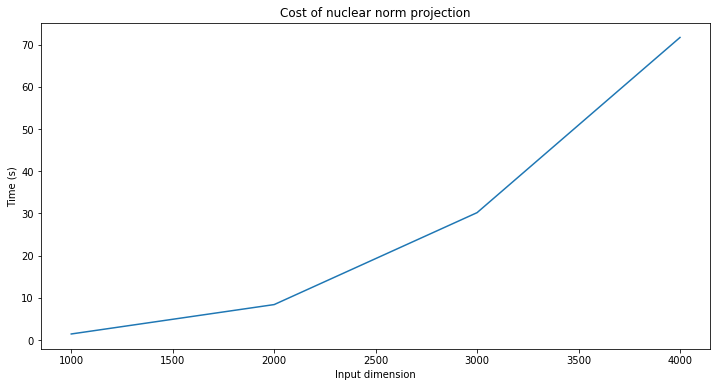

In [67]:
plt.figure(figsize=(12,6))
plt.xlabel('Input dimension')
plt.ylabel('Time (s)')
plt.title('Cost of nuclear norm projection')
plt.plot(ns, ts)